# Recommender Systems in R - Collabrative filtering

In [1]:
#######################################################
# Implicit Ratings Workshop
#######################################################

# NASA website serverlog events dataset (http requests)
# this is tranaction format, has one line per http request
# this is NOT ratings data, we use use pageview counts as proxy for ratings
# goal is to make pageview (content) recommendations

In [2]:
file = "/Users/mohameddhameemm/Documents/NUS Mtech/Semester 3/Data Mining/Day 7/Workshop/access_log_Aug95.txt"

In [6]:
##below are the helper class. Please load to memory first
###############################################################
# simple user-user and item-item collaborative filtering
# using ratings data in tabular format (rows as items, columns as users)
################################################################
#Collabrative filtering - helper class

library(Matrix)
library(stringr)
library(reshape2)
library(compiler)

# User-User CF
getrecommendations_UU <- function(target, items, topN=5, FUN = cosinesim) {
  # compute similarity between target and all other users
  sims = apply(items[,!names(items) %in% target],2,function(user) FUN(user,items[,target]))
  sims = sims[!is.na(sims) & sims >=0]
  notseenitems = which(is.na(items[,target]))
  wavrats = apply(items[notseenitems,names(sims)],1,function(rats) weighted.mean(rats, sims, na.rm=TRUE))
  s = sort(wavrats[!is.na(wavrats)], decreasing = TRUE)
  if (topN == FALSE) s else s[1:min(topN,length(s))] # get topN items
}
getrecommendations_UU = cmpfun(getrecommendations_UU)

# compute the item-item similarity matrix (the matrix is symmetric so compute half & copy)
getitemsimsmatrix = function(items, FUN = cosinesim) {
  rw <<- 1
  itemsims = apply(items, 1, function(itemA) {
    rw <<- rw + 1 ; cl <<- 1; cat(".")
    apply(items,1,function(itemB) {cl<<-cl+1; if (cl<rw) NA else if (cl==rw) 1 else FUN(itemA,itemB)})
  })
  m = forceSymmetric(itemsims,uplo="L") # copy lower half to upper half
  as.matrix(m)
}
getitemsimsmatrix = cmpfun(getitemsimsmatrix)

getusersims = function(target, items, FUN = cosinesim) {
}

euclidsim = function(x,y) { 1/(1+sqrt(sum((y-x)^2,na.rm=TRUE))) }
euclidsimF= function(x,y) { 1/(1+(sum((y-x)^2,na.rm=TRUE))) } # faster if only ranking is required (as dome in book)
cosinesim = function(x,y) { xy = x*y; sum(xy, na.rm=TRUE)/(sqrt(sum(x[!is.na(xy)]^2)*sum(y[!is.na(xy)]^2)))}
jacardsim = function(x,y) { validx= !is.na(x) ; validy= !is.na(y); sum(as.integer(validx&validy))/sum(as.integer(validx|validy))} # not efficient
pearsonsim= function(x,y) { suppressWarnings(cor(x,y,use="pairwise.complete.obs")) }

# How sparse is the data in a data frame? Compute % of non-blank entries
fillrate = function(df) {cat((length(which(!is.na(df)))*100)/(nrow(df)*ncol(df)),"%")}
fillrate = cmpfun(fillrate)

# same as above but works on dataframes and vectors
fillratev = function(df) {t=unlist(df); cat((length(which(!is.na(t)))*100)/length(t),"%")}
fillratev = cmpfun(fillratev)

# how many values are > 0? Compute % of entries > 0
posrate = function(df) {t=unlist(df); cat((length(which(!is.na(t) & t > 0))*100)/length(t),"%")}

# get recommedations for the target user using item-item CF
getrecommendations_II <- function(target, items, itemsims, topN=5) {
  seenitems = !is.na(items[,target])
  unseenitems = is.na(items[,target])
  seenrats = items[seenitems,target]
  preds = apply(itemsims[unseenitems,seenitems], 1, function(simrow) weighted.mean(seenrats, simrow, na.rm=TRUE))
  s = sort(preds[!is.na(preds)] , decreasing = TRUE)
  s[1:min(topN,length(s))]  # get topN items
}
getrecommendations_II = cmpfun(getrecommendations_II)

# make predicted ratings for a sample of items for each test user
predictCF = function(testusers, itemrats, trainusers=FALSE, itemsims=FALSE, ratings=TRUE, numtestitems=10, random=FALSE, simfun=pearsonsim) {
  sapply(testusers,function(testuser)
    predict2(testuser,itemrats,trainusers=trainusers,itemsims=itemsims,ratings=ratings,numtestitems=numtestitems,random=random, simfun=simfun))
}

predict2 <- function(targetname,itemrats,trainusers,itemsims,ratings,numtestitems,random, simfun) {
  seenitems   = which(!is.na(itemrats[,targetname]))
  if (random) testitems = sample(seenitems,min(numtestitems,length(seenitems))) # random N items
  else testitems = seenitems[1:min(numtestitems,length(seenitems))] # first N items
  cat(".")
  preds = list()
  for (testitem in testitems) {
    testitemname = row.names(itemrats[testitem,])
    truerating = itemrats[testitem, targetname] # make a copy of actual rating
    itemrats[testitem, targetname] = NA # temporarily set as unseen
    if (length(trainusers) > 1) {     # do user-user CF
      usersims = apply(itemrats[,!colnames(itemrats) %in% targetname],2,function(urats) simfun(urats,itemrats[,targetname]))
      usersims = usersims[!is.na(usersims) & usersims >=0]
      predictedrating = weighted.mean(itemrats[testitem,names(usersims)], usersims, na.rm=TRUE)
    }
    else { # do item-items CF
      if (ratings)  predictedrating = my.weighted.mean(itemrats[seenitems,targetname], itemsims[seenitems,testitem])
      else          predictedrating = my.weighted.mean(itemsims[seenitems,testitem],   itemrats[seenitems,targetname])
    }
    itemrats[testitem, targetname] = truerating # restore the actual rating
    preds = c(preds,predictedrating,truerating)
  }
  m = as.matrix(preds)
  if (length(m) < numtestitems*2) for (i in (length(m)+1):(numtestitems*2)) { m = rbind(m,NA)}
  return(m)
}
predict2= cmpfun(predict2)

# a weighted mean that handles NA's in both arguments (ratings and similarities)
my.weighted.mean = function(x,y) { xy = x*y; sum(xy,na.rm=TRUE) / sum(y[!is.na(xy)]) }
my.weighted.mean = cmpfun(my.weighted.mean)

avgMAE = function(preds) {
  plist = unlist(preds)
  errors = sapply(1:(length(plist)/2),function(i) abs(plist[i*2-1]-plist[i*2]))
  mean(errors,na.rm=TRUE)
}

showCM = function(preds, like) {
  plist = unlist(preds)
  cnts = sapply(1:(length(plist)/2), function(i) {
    pred = plist[i*2-1] ; actual = plist[i*2]
    if (!is.na(pred) & !is.nan(actual)) {
      if (pred>=like) {if(actual>=like) c(1,0,0,0) else c(0,1,0,0)}
      else if(actual<like) c(0,0,1,0) else c(0,0,0,1) 
    } else c(0,0,0,0)
  })
  s = rowSums(cnts)   #returns cnts for: TP, FP, TN, FN
  cat(sprintf("accuracy = %0.1f%%\n", (s[1]+s[3])*100/sum(s)))
  cat(sprintf("TN=%3d FP=%3d\n",s[3],s[2]))
  cat(sprintf("FN=%3d TP=%3d     recall=%0.1f%%\n",s[4],s[1],s[1]*100/(s[1]+s[4])))
  cat(sprintf("       pr= %3.1f%%",s[1]*100/(s[1]+s[2])))
}


In [7]:
# load and preprocess the data (keep only pageview events)
events = read.csv(file, sep = "", stringsAsFactors=TRUE, quote="", header=FALSE)
names(events) = c("host","x","y","time","zone","get","request","http", "reply","bytes")

In [8]:
events = subset(events,select=c("host","request"))
head(events,20); dim(events)

host,request
in24.inetnebr.com,/shuttle/missions/sts-68/news/sts-68-mcc-05.txt
uplherc.upl.com,/
uplherc.upl.com,/images/ksclogo-medium.gif
uplherc.upl.com,/images/MOSAIC-logosmall.gif
uplherc.upl.com,/images/USA-logosmall.gif
ix-esc-ca2-07.ix.netcom.com,/images/launch-logo.gif
uplherc.upl.com,/images/WORLD-logosmall.gif
slppp6.intermind.net,/history/skylab/skylab.html
piweba4y.prodigy.com,/images/launchmedium.gif
slppp6.intermind.net,/history/skylab/skylab-small.gif


[1] 1570730       2

In [9]:
pageviews = str_detect(events$request,"html")
events = events[pageviews,]   # keep only pageview events
dim(events)

[1] 333448      2

In [10]:
# do some data exploration (follow CRISP), e.g. examine the popular requests
temp = sort(table(events$request), decreasing = TRUE)
length(temp) # number of unique requests
head(temp,100) # show top requests

[1] 15702


                                           /ksc.html 
                                               43619 
        /shuttle/missions/sts-69/mission-sts-69.html 
                                               24592 
                     /shuttle/missions/missions.html 
                                               22429 
                          /software/winvn/winvn.html 
                                               10343 
                               /history/history.html 
                                               10111 
                         /history/apollo/apollo.html 
                                                8973 
                     /shuttle/countdown/liftoff.html 
                                                7858 
            /history/apollo/apollo-13/apollo-13.html 
                                                7160 
     /shuttle/technology/sts-newsref/stsref-toc.html 
                                                6506 
         /shuttle/missions/

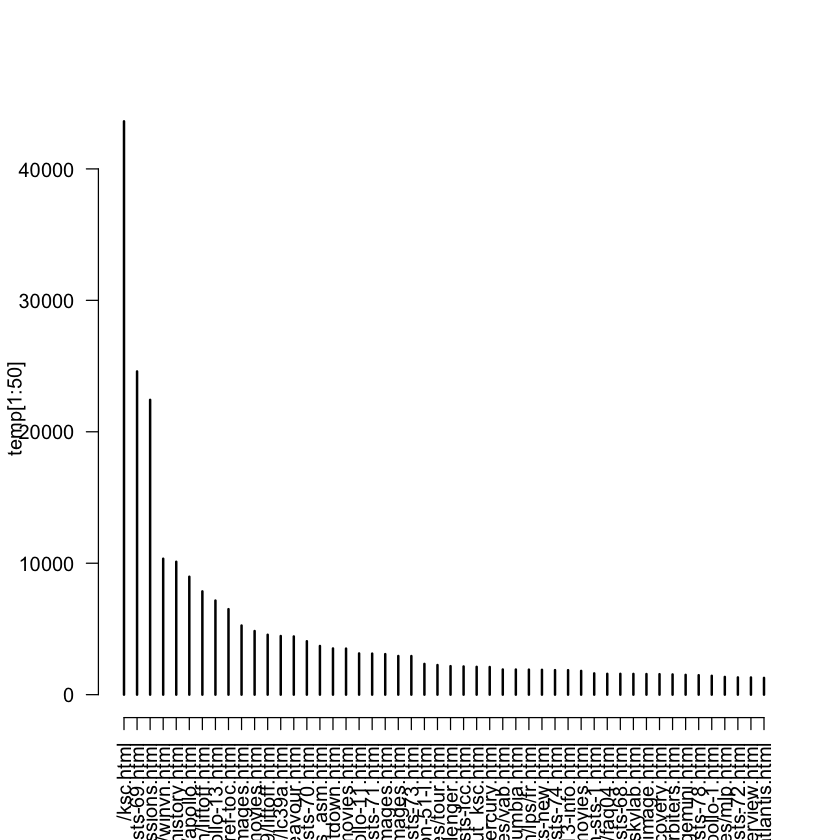

In [11]:
plot(temp[1:50],las=2) # plot top 20 frequency requests (las=2 => verical labels)

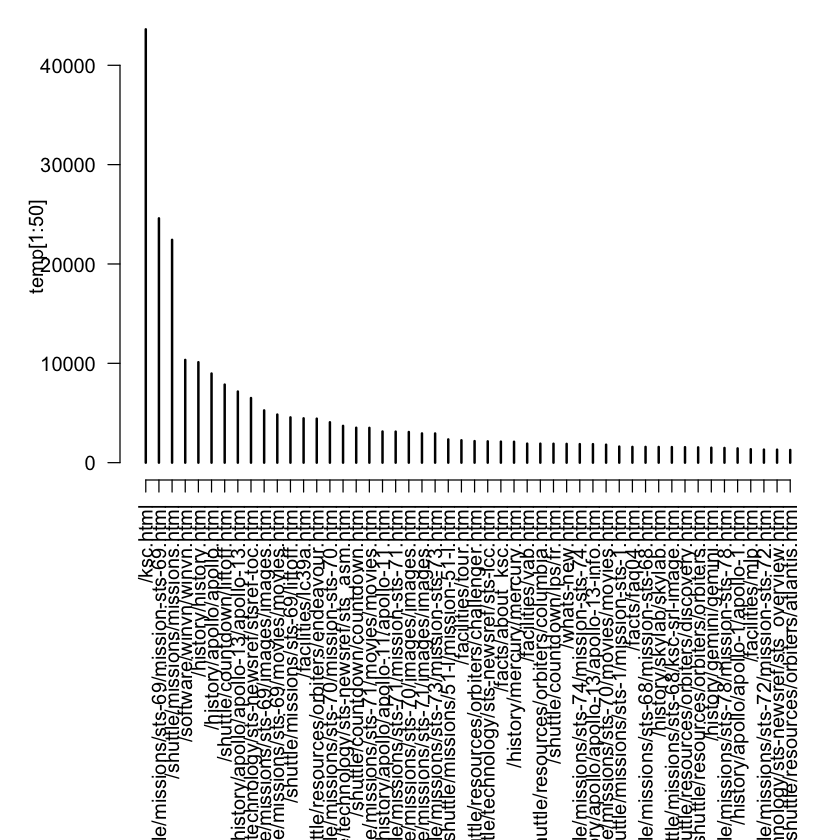

In [13]:
par(mai=c(3,1,0.1,0.2)) # set plot margins in inches (bottom,left,top,right)
plot(temp[1:50],las=2) # plot top 20 frequency requests

In [14]:
# to simplify we could just take the last part of the URL (page title)
temp = str_extract(events$request, "\\/[^\\/]*$") # gets everything after last "/"
head(temp,100)
length(unique(temp)) # show number of unique items (pages)

[1] "/skylab.html"         "/mission-sts-69.html" "/apollo-16.html"     
  [4] "/discovery.html"      "/skylab-1.html"       "/mission-sts-71.html"
  [7] "/endeavour.html"      "/atlantis.html"       "/challenger.html"    
 [10] "/apollo-17.html"      "/history.html"        "/history.html"       
 [13] "/images.html"         "/mission-sts-72.html" "/lc39a.html"         
 [16] "/jmd.html"            "/apollo.html"         "/count.html"         
 [19] "/ksc-srl-image.html"  "/mission-sts-71.html" "/countdown.html"     
 [22] "/ksc.html"            "/mission-sts-49.html" "/apollo-13.html"     
 [25] "/apollo.html"         "/procurement.html"    "/liftoff.html"       
 [28] "/mlp.html"            "/skylab-2.html"       "/movies.html"        
 [31] "/history.html"        "/mission-sts-73.html" "/mission-sts-71.html"
 [34] "/sts_asm.html"        "/facts.html"          "/faq01.html"         
 [37] "/winvn.html"          "/mission-sts-70.html" "/movies.html"        
 [40] "/lc39a.html"          "/discovery.html"      "/endeavour.html"     
 [43] "/ksc.html"            "/mission-sts-49.html" "/fr.html"            
 [46] "/images.html"         "/apollo-13.html"      "/missions.html"      
 [49] "/bkup-intg.html"      "/100th.html"          "/winvn.html"         
 [52] "/mission-sts-57.html" "/mission-sts-70.html" "/movies.html"        
 [55] "/images.html"         "/mission-sts-70.html" "/winvn.html"         
 [58] "/mission-sts-57.html" "/winvn.html"          "/wvnguide.html"      
 [61] "/lc39a.html"          "/ksc.html"            "/winvn.html"         
 [64] "/gemini.html"         "/winvn.html"          "/discovery.html"     
 [67] "/apollo-13.html"      "/apollo.html"         "/ksc-srl-image.html" 
 [70] "/mlp.html"            "/apollo-13.html"      "/mission-sts-66.html"
 [73] "/endeavour.html"      "/mission-sts-71.html" "/gemini.html"        
 [76] "/ksc.html"            "/mission-sts-63.html" "/discovery.html"     
 [79] "/movies.html"         "/endeavour.html"      "/mission-sts-70.html"
 [82] "/lc39a.html"          "/history.html"        "/apollo.html"        
 [85] "/apollo-13.html"      "/mission-sts-26.html" "/apollo-13-info.html"
 [88] "/apollo-13.html"      "/apollo-13.html"      "/missions.html"      
 [91] "/astro_home.html"     "/mission-sts-68.html" "/sts_asm.html"       
 [94] "/facts.html"          "/mission-sts-68.html" "/apollo-13-info.html"
 [97] "/mission-sts-1.html"  "/faq07.html"          "/stsref-toc.html"    
[100] "/apollo.html"

[1] 1100

In [15]:
# Or roll-up one level (requests are now page categories)
temp = str_extract(events$request, "^.*\\/") # gets everything up to last "/"
head(temp,100)

[1] "/history/skylab/"                  "/shuttle/missions/sts-69/"        
  [3] "/history/apollo/apollo-16/"        "/shuttle/resources/orbiters/"     
  [5] "/history/skylab/"                  "/shuttle/missions/sts-71/"        
  [7] "/shuttle/resources/orbiters/"      "/shuttle/resources/orbiters/"     
  [9] "/shuttle/resources/orbiters/"      "/history/apollo/apollo-17/"       
 [11] "/history/"                         "/history/"                        
 [13] "/shuttle/missions/sts-71/images/"  "/shuttle/missions/sts-72/"        
 [15] "/facilities/"                      "/persons/nasa-cm/"                
 [17] "/history/apollo/"                  "/shuttle/countdown/"              
 [19] "/shuttle/missions/sts-68/"         "/shuttle/missions/sts-71/"        
 [21] "/shuttle/countdown/"               "/"                                
 [23] "/shuttle/missions/sts-49/"         "/history/apollo/apollo-13/"       
 [25] "/history/apollo/"                  "/procurement/"                    
 [27] "/shuttle/countdown/"               "/facilities/"                     
 [29] "/history/skylab/"                  "/shuttle/missions/sts-70/movies/" 
 [31] "/history/"                         "/shuttle/missions/sts-73/"        
 [33] "/shuttle/missions/sts-71/"         "/shuttle/technology/sts-newsref/" 
 [35] "/facts/"                           "/facts/"                          
 [37] "/software/winvn/"                  "/shuttle/missions/sts-70/"        
 [39] "/shuttle/missions/sts-71/movies/"  "/facilities/"                     
 [41] "/shuttle/resources/orbiters/"      "/shuttle/resources/orbiters/"     
 [43] "/"                                 "/shuttle/missions/sts-49/"        
 [45] "/shuttle/countdown/lps/"           "/shuttle/missions/sts-70/images/" 
 [47] "/history/apollo/apollo-13/"        "/shuttle/missions/"               
 [49] "/shuttle/countdown/lps/bkup-intg/" "/shuttle/missions/"               
 [51] "/software/winvn/"                  "/shuttle/missions/sts-57/"        
 [53] "/shuttle/missions/sts-70/"         "/shuttle/missions/sts-71/movies/" 
 [55] "/shuttle/missions/sts-71/images/"  "/shuttle/missions/sts-70/"        
 [57] "/software/winvn/"                  "/shuttle/missions/sts-57/"        
 [59] "/software/winvn/"                  "/software/winvn/userguide/"       
 [61] "/facilities/"                      "/"                                
 [63] "/software/winvn/"                  "/history/gemini/"                 
 [65] "/software/winvn/"                  "/shuttle/resources/orbiters/"     
 [67] "/history/apollo/apollo-13/"        "/history/apollo/"                 
 [69] "/shuttle/missions/sts-68/"         "/facilities/"                     
 [71] "/history/apollo/apollo-13/"        "/shuttle/missions/sts-66/"        
 [73] "/shuttle/resources/orbiters/"      "/shuttle/missions/sts-71/"        
 [75] "/history/gemini/"                  "/"                                
 [77] "/shuttle/missions/sts-63/"         "/shuttle/resources/orbiters/"     
 [79] "/shuttle/missions/sts-70/movies/"  "/shuttle/resources/orbiters/"     
 [81] "/shuttle/missions/sts-70/"         "/facilities/"                     
 [83] "/history/"                         "/history/apollo/"                 
 [85] "/history/apollo/apollo-13/"        "/shuttle/missions/sts-26/"        
 [87] "/history/apollo/apollo-13/"        "/history/apollo/apollo-13/"       
 [89] "/history/apollo/apollo-13/"        "/shuttle/missions/"               
 [91] "/msfc/"                            "/shuttle/missions/sts-68/"        
 [93] "/shuttle/technology/sts-newsref/"  "/facts/"                          
 [95] "/shuttle/missions/sts-68/"         "/history/apollo/apollo-13/"       
 [97] "/shuttle/missions/sts-1/"          "/facts/"                          
 [99] "/shuttle/technology/sts-newsref/"  "/history/apollo/"

In [16]:
length(unique(temp)) # show number of unique items (page categories)
sort(unique(temp)) # items 150,245,308,309,392,429,436,446,471 could be logfile bugs (check using grep on the logfile)

[1] 515

[1] "/"                                                                  
  [2] "/%20history/apollo/apollo-13/"                                      
  [3] "/%7Emccoy/Icons/"                                                   
  [4] "/.../"                                                              
  [5] "//"                                                                 
  [6] "//facilities/"                                                      
  [7] "//facts/"                                                           
  [8] "//history/apollo/"                                                  
  [9] "//ksc/"                                                             
 [10] "//procurement/"                                                     
 [11] "//shuttle/missions/"                                                
 [12] "//shuttle/missions/sts-71/"                                         
 [13] "//software/winvn/"                                                  
 [14] "/128.159.104.89/tv/"                                                
 [15] "/HTML/"                                                             
 [16] "/Home/NetworkSecurity/Firewalls/"                                   
 [17] "/LDAR/"                                                             
 [18] "/OFFICE/pao/newsroom/"                                              
 [19] "/SDG/Software/Mosaic/StartingPoints/"                               
 [20] "/SDG/Software/WinMosaic/"                                           
 [21] "/Shuttle/"                                                          
 [22] "/Shuttle/mission/"                                                  
 [23] "/Shuttle/missions/STS-69/images/"                                   
 [24] "/Shuttle/missions/sts-69/images/"                                   
 [25] "/Software/winvn/"                                                   
 [26] "/X500/"                                                             
 [27] "/apod/"                                                             
 [28] "/apod/lib/"                                                         
 [29] "/apollo/"                                                           
 [30] "/apollo/apollo-13/"                                                 
 [31] "/base-ops/procurement/"                                             
 [32] "/biomed/"                                                           
 [33] "/biomed/bibliography/"                                              
 [34] "/biomed/climate/"                                                   
 [35] "/biomed/fire/"                                                      
 [36] "/biomed/glossary/"                                                  
 [37] "/biomed/history/"                                                   
 [38] "/biomed/soils/"                                                     
 [39] "/biomed/threat/"                                                    
 [40] "/biomed/vegetation/"                                                
 [41] "/biomed/watqual/"                                                   
 [42] "/biomed/wetlands/"                                                  
 [43] "/calendar/"                                                         
 [44] "/chuttle/missions/"                                                 
 [45] "/climate/"                                                          
 [46] "/coundown/"                                                         
 [47] "/de/"                                                               
 [48] "/elv/"                                                              
 [49] "/escapes/"                                                          
 [50] "/facilities/"                                                       
 [51] "/facilities/m/"                                                     
 [52] "/facilities/spaceport.html/"                                        
 [53] "/facts/"                                   

In [17]:
temp2 = str_extract(temp, "^.*html") # gets everything up to html "/"
length(unique(temp2))
unique(temp2[!is.na(temp2)])
temp2 = str_replace(temp,"[^\\/]*html","") # gets "html" and all non "/" chars in front of it
length(temp2)
sort(unique(temp2))

[1] 33

[1] "/ksc.html"                                      
 [2] "/shuttle/countdown/countdown.html"              
 [3] "/shuttle/missions/missions.html"                
 [4] "/history/apollo-13/apollo-13.html"              
 [5] "/facts/faq11.html"                              
 [6] "/msfc/astro_home.html"                          
 [7] "/history/apollo/apollo-13/apollo-13.html"       
 [8] "/html"                                          
 [9] "/nfs/hp0257/www/mech_sys/toolbox/AppswHome.html"
[10] "/software/winvn/winvn.html"                     
[11] "/history/apollo/apollo-11/apollo-11.html"       
[12] "/facilities/spaceport.html"                     
[13] "/shuttle/missions/mission.html"                 
[14] "/spftware/winvn/winvn.html"                     
[15] "/software/winvn.html"                           
[16] "/shusts-newsref/stsref-toc.html"                
[17] "/shuttle/technology/sts-newsref/stsref-toc.html"
[18] "/internet/mosaic/html"                          
[19] "/shuttle/resources/orbiters.html"               
[20] "/shuttle/missions/51-l/mission-51-l.html"       
[21] "/shuttle/missions/41-c/mission-41-c.html"       
[22] "/shuttle/mission/41-g/mission-41-g.html"        
[23] "/shuttle/missions/sts-69/mission-sts-69.html"   
[24] "/shuttle/missions/sts-69/movies/movies.html"    
[25] "/~mccoy/icons/index.html"                       
[26] "/history/mercury/mr-3/mr-3.html"                
[27] "/shuttle/missions/sts-69/liftoff.html"          
[28] "/history/history.html"                          
[29] "/shuttle/countdown/liftoff.html"                
[30] "/shuttle/technolgy/sts-newsref/sts-eps.html"    
[31] "/software/winvin/winvin.html"                   
[32] "/procurement.html"

[1] 333448

[1] "/"                                                         
  [2] "/%20history/apollo/apollo-13/"                             
  [3] "/%7Emccoy/Icons/"                                          
  [4] "/.../"                                                     
  [5] "//"                                                        
  [6] "//Library/Florida/"                                        
  [7] "//elv/"                                                    
  [8] "//facilities/"                                             
  [9] "//facts/"                                                  
 [10] "//history/"                                                
 [11] "//history/apollo/"                                         
 [12] "//images/"                                                 
 [13] "//ksc/"                                                    
 [14] "//procurement/"                                            
 [15] "//shuttle/missions/"                                       
 [16] "//shuttle/missions/sts-71/"                                
 [17] "//shuttle/technology/sts-newsref/"                         
 [18] "//software/winvn/"                                         
 [19] "/128.159.104.89/tv/"                                       
 [20] "/HTML/"                                                    
 [21] "/Home/NetworkSecurity/Firewalls/"                          
 [22] "/LDAR/"                                                    
 [23] "/OFFICE/pao/newsroom/"                                     
 [24] "/SDG/Software/Mosaic/StartingPoints/"                      
 [25] "/SDG/Software/WinMosaic/"                                  
 [26] "/Shuttle/"                                                 
 [27] "/Shuttle/mission/"                                         
 [28] "/Shuttle/missions/STS-69/images/"                          
 [29] "/Shuttle/missions/sts-69/images/"                          
 [30] "/Software/winvn/"                                          
 [31] "/X500/"                                                    
 [32] "/apod/"                                                    
 [33] "/apod/lib/"                                                
 [34] "/apollo/"                                                  
 [35] "/apollo/apollo-13/"                                        
 [36] "/base-ops/procurement/"                                    
 [37] "/biomed/"                                                  
 [38] "/biomed/bibliography/"                                     
 [39] "/biomed/climate/"                                          
 [40] "/biomed/fire/"                                             
 [41] "/biomed/glossary/"                                         
 [42] "/biomed/history/"                                          
 [43] "/biomed/soils/"                                            
 [44] "/biomed/threat/"                                           
 [45] "/biomed/vegetation/"                                       
 [46] "/biomed/watqual/"                                          
 [47] "/biomed/wetlands/"                                         
 [48] "/calendar/"                                                
 [49] "/chuttle/missions/"                                        
 [50] "/climate/"                                                 
 [51] "/coundown/"                                                
 [52] "/de/"                                                      
 [53] "/ed/"                                                      
 [54] "/elv/"                                                     
 [55] "/escapes/"                                                 
 [56] "/facilities/"                                              
 [57] "/facilities//"                                             
 [58] "/facilities/m/"                                            
 [59] "/facts/"                                                   
 [60] "/facts/internet/"                         

In [18]:
# could do further (goal-specific) roll-ups, e.g: ignore eveything after "countdown"
unique(temp2[str_detect(temp2,"countdown")])
temp3 = str_replace(temp2,"countdown.*$","countdown")
sort(unique(temp3))

[1] "/shuttle/countdown/"               "/shuttle/countdown/lps/"          
 [3] "/shuttle/countdown/lps/bkup-intg/" "/shuttle/countdown/lps/osr/"      
 [5] "/shuttle/countdown/lps/aa/"        "/shuttle/countdown/lps/hsp/"      
 [7] "/shuttle/countdown/lps/c-7-8/"     "/shuttle/countdown/lps/mstr/"     
 [9] "/shuttle/countdown/lps/ac/"        "/shuttle/countdown/lps/c-11-12/"  
[11] "/shuttle/countdown/lps/omr/"       "/shuttle/countdown/lps/c-2/"      
[13] "/shuttle/countdown/lps/c-1/"       "/shuttle/countdown/lps/c-5-6/"    
[15] "/shuttle/countdown/lps/c-9-10/"    "/shuttle/countdown//"             
[17] "/shuttle/countdown/lps/ab/"        "/shuttle/countdown/lps/c-3-4/"    
[19] "/www/shuttle/countdown/"           "/shuttle/countdown/video/"

[1] "/"                                                         
  [2] "/%20history/apollo/apollo-13/"                             
  [3] "/%7Emccoy/Icons/"                                          
  [4] "/.../"                                                     
  [5] "//"                                                        
  [6] "//Library/Florida/"                                        
  [7] "//elv/"                                                    
  [8] "//facilities/"                                             
  [9] "//facts/"                                                  
 [10] "//history/"                                                
 [11] "//history/apollo/"                                         
 [12] "//images/"                                                 
 [13] "//ksc/"                                                    
 [14] "//procurement/"                                            
 [15] "//shuttle/missions/"                                       
 [16] "//shuttle/missions/sts-71/"                                
 [17] "//shuttle/technology/sts-newsref/"                         
 [18] "//software/winvn/"                                         
 [19] "/128.159.104.89/tv/"                                       
 [20] "/HTML/"                                                    
 [21] "/Home/NetworkSecurity/Firewalls/"                          
 [22] "/LDAR/"                                                    
 [23] "/OFFICE/pao/newsroom/"                                     
 [24] "/SDG/Software/Mosaic/StartingPoints/"                      
 [25] "/SDG/Software/WinMosaic/"                                  
 [26] "/Shuttle/"                                                 
 [27] "/Shuttle/mission/"                                         
 [28] "/Shuttle/missions/STS-69/images/"                          
 [29] "/Shuttle/missions/sts-69/images/"                          
 [30] "/Software/winvn/"                                          
 [31] "/X500/"                                                    
 [32] "/apod/"                                                    
 [33] "/apod/lib/"                                                
 [34] "/apollo/"                                                  
 [35] "/apollo/apollo-13/"                                        
 [36] "/base-ops/procurement/"                                    
 [37] "/biomed/"                                                  
 [38] "/biomed/bibliography/"                                     
 [39] "/biomed/climate/"                                          
 [40] "/biomed/fire/"                                             
 [41] "/biomed/glossary/"                                         
 [42] "/biomed/history/"                                          
 [43] "/biomed/soils/"                                            
 [44] "/biomed/threat/"                                           
 [45] "/biomed/vegetation/"                                       
 [46] "/biomed/watqual/"                                          
 [47] "/biomed/wetlands/"                                         
 [48] "/calendar/"                                                
 [49] "/chuttle/missions/"                                        
 [50] "/climate/"                                                 
 [51] "/coundown/"                                                
 [52] "/de/"                                                      
 [53] "/ed/"                                                      
 [54] "/elv/"                                                     
 [55] "/escapes/"                                                 
 [56] "/facilities/"                                              
 [57] "/facilities//"                                             
 [58] "/facilities/m/"                                            
 [59] "/facts/"                                                   
 [60] "/facts/internet/"                         

In [19]:
# copy the cleaned requests back into events
events$request = as.factor(temp2)
length(unique(events$request))

[1] 507

In [20]:
rm(temp); rm(temp2); rm(temp3)

In [21]:
# convert to table format using the reshape2 library (takes a few minutes)
# below code truncates page-cat counts at 2 ("ratings" ~ 0=>no PV, 1 => 1 PV, 2 => many PV's)
g = acast(events, host ~ request, value.var = "request", fun.aggregate = function(x) min(2,length(x))) 

In [22]:
g[1:10,1:20]

,/,/%20history/apollo/apollo-13/,/%7Emccoy/Icons/,/.../,//,//Library/Florida/,//elv/,//facilities/,//facts/,//history/,//history/apollo/,//images/,//ksc/,//procurement/,//shuttle/missions/,//shuttle/missions/sts-71/,//shuttle/technology/sts-newsref/,//software/winvn/,/128.159.104.89/tv/,/HTML/
***.novo.dk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
001.msy4.communique.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
01-dynamic-c.wokingham.luna.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
01.ts01.zircon.net.au,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
02-17-05.comsvc.calpoly.edu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
023.msy4.communique.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
03-dynamic-c.wokingham.luna.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0321jona.jon.rpslmc.edu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
033.msy4.communique.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
049.215.goodnet.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
rm(events)

In [24]:
# zero counts do not imply "not-like" so change zeros to NA
g = apply(g,2,function(c) sapply(c, function(x) if (x==0) NA else x)) # takes a few minutes to run
items <- as.data.frame(t(as.data.frame(g)))
dim(items)

[1]   507 64455

In [25]:
rm(g)

In [26]:
fillrate(items) # very low, hence similarity measurements may be poor?

0.5976709 %

In [27]:
# look at the unique host names
head(sort(unique(colnames(items))),100)

[1] "***.novo.dk"                     "001.msy4.communique.net"        
  [3] "01-dynamic-c.wokingham.luna.net" "01.ts01.zircon.net.au"          
  [5] "02-17-05.comsvc.calpoly.edu"     "023.msy4.communique.net"        
  [7] "03-dynamic-c.wokingham.luna.net" "0321jona.jon.rpslmc.edu"        
  [9] "033.msy4.communique.net"         "049.215.goodnet.com"            
 [11] "05-dynamic-c.wokingham.luna.net" "052.215.goodnet.com"            
 [13] "07mb369b.uni-duisburg.de"        "08-dynamic-c.rotterdam.luna.net"
 [15] "0875pr3e.pro.rpslmc.edu"         "1.ts1.mnet.medstroms.se"        
 [17] "1.ts2.mnet.medstroms.se"         "10.ts2.mnet.medstroms.se"       
 [19] "101.irri.cgiar.org"              "1032015.ksc.nasa.gov"           
 [21] "107.tcom.co.uk"                  "10forward.ppp.america.com"      
 [23] "10md423.uni-duisburg.de"         "11.ts1.mnet.medstroms.se"       
 [25] "110.the-spa.com"                 "118.32.med.umich.edu"           
 [27] "12-102eb.itslab.calpoly.edu"     "12-105da.acs.calpoly.edu"       
 [29] "12-105he.acs.calpoly.edu"        "12-105id.acs.calpoly.edu"       
 [31] "12.ts2.mnet.medstroms.se"        "120.33.med.umich.edu"           
 [33] "120cc-pc-11.cl.msu.edu"          "121.27.inmarsat.org"            
 [35] "128.100.125.62"                  "128.100.160.162"                
 [37] "128.100.180.37"                  "128.100.183.252"                
 [39] "128.100.183.253"                 "128.100.191.43"                 
 [41] "128.100.197.90"                  "128.100.8.177"                  
 [43] "128.100.80.97"                   "128.100.83.132"                 
 [45] "128.100.88.42"                   "128.100.95.2"                   
 [47] "128.101.144.178"                 "128.101.42.229"                 
 [49] "128.101.62.101"                  "128.101.96.143"                 
 [51] "128.101.96.159"                  "128.101.96.33"                  
 [53] "128.101.96.70"                   "128.102.101.127"                
 [55] "128.102.143.191"                 "128.102.143.192"                
 [57] "128.102.143.193"                 "128.102.143.200"                
 [59] "128.102.143.201"                 "128.102.143.204"                
 [61] "128.102.143.212"                 "128.102.143.214"                
 [63] "128.102.143.217"                 "128.102.146.223"                
 [65] "128.102.147.16"                  "128.102.149.149"                
 [67] "128.102.149.200"                 "128.102.152.201"                
 [69] "128.102.156.65"                  "128.102.202.133"                
 [71] "128.102.204.239"                 "128.102.204.241"                
 [73] "128.102.210.40"                  "128.102.236.36"                 
 [75] "128.102.244.7"                   "128.102.31.173"                 
 [77] "128.102.86.216"                  "128.103.127.163"                
 [79] "128.103.128.142"                 "128.103.196.21"                 
 [81] "128.103.227.218"                 "128.104.200.160"                
 [83] "128.104.200.4"                   "128.104.225.17"                 
 [85] "128.104.225.29"                  "128.104.235.113"                
 [87] "128.104.26.50"                   "128.104.39.218"                 
 [89] "128.110.107.152"                 "128.110.112.26"                 
 [91] "128.110.194.51"                  "128.110.42.60"                  
 [93] "128.111.114.74"                  "128.111.124.55"                 
 [95] "128.111.142.16"                  "128.111.142.31"                 
 [97] "128.111.144.127"                 "128.111.206.130"                
 [99] "128.111.215.1"                   "128.111.224.121"

In [30]:
target = "128.100.125.62"
getrecommendations_UU(target, items)
length(which(!is.na(items[,target]))) # how many page-categories has the target seen?

//Library/Florida/                     /LDAR/ 
                         2                          2 
/history/aopllo/apollo-13/                 /missions/ 
                         2                          2 
         /missions/sts-70/ 
                         2

[1] 1

In [31]:
target = "128.100.180.37"
getrecommendations_UU(target, items)
length(which(!is.na(items[,target]))) # how many page-categories has the target seen?

//Library/Florida/           //facts/          //images/              /elv/ 
                 2                  2                  2                  2 
          /gemini/ 
                 2

[1] 1

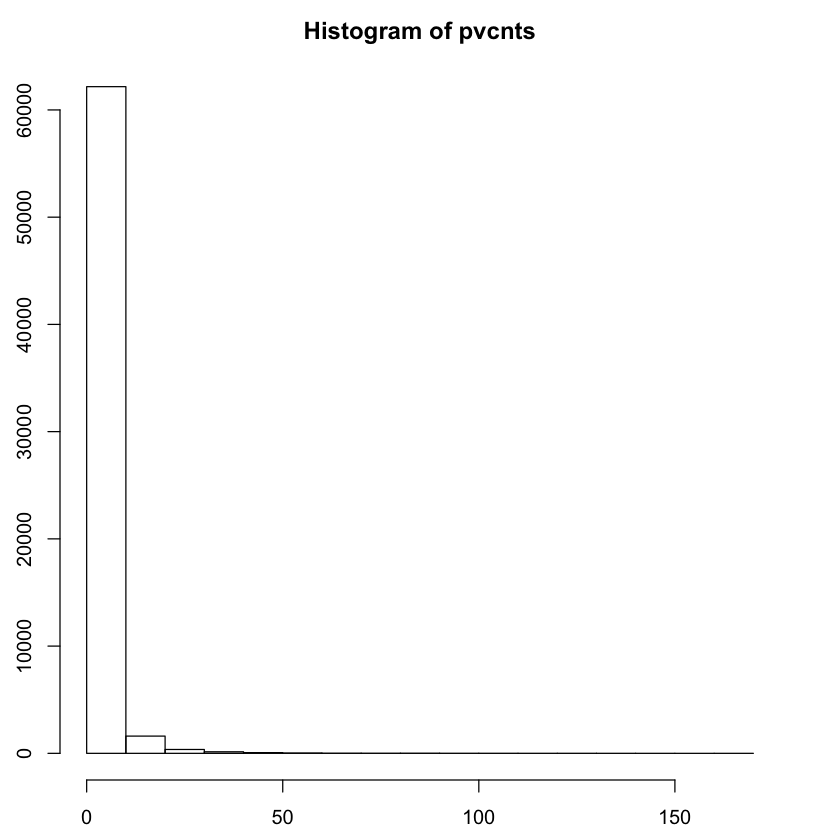

In [32]:
# find targets (hosts) who can be recommended to (have enough pageviews)
pvcnts = sapply(colnames(items), function(host) length(which(!is.na(items[,host])))) # count pageviews for each host
par(mai=c(0.5,0.5,0.5,0.5)) # reset plot margins
hist(pvcnts)

In [34]:
activehosts = which(pvcnts >= 10)
length(activehosts)  # show number of hosts that have viewed >=10 different pageview categories
head(activehosts)

[1] 2783

128.100.197.90 128.115.171.249   128.118.73.85   128.119.70.46   128.149.9.161 
             41             109             117             121             225 
128.158.128.219 
            237

In [35]:
target = "128.100.197.90"
length(which(!is.na(items[,target])))  # show #pageview-categories that the target has viewed
getrecommendations_UU(target, items, topN = 20)

[1] 13

//Library/Florida/ 
                                       2 
                               //images/ 
                                       2 
                               /Shuttle/ 
                                       2 
                     /biomed/vegetation/ 
                                       2 
                               /hisorty/ 
                                       2 
              /history/aopllo/apollo-13/ 
                                       2 
                  /history/apollo/a-005/ 
                                       2 
                  /history/mercury/ma-5/ 
                                       2 
                                  /home/ 
                                       2 
                       /missions/sts-70/ 
                                       2 
      /nfs/hp0257/www/mech_sys/toolbox// 
                                       2 
                    /resources/orbiters/ 
                                       2 
                              /s...sref/ 
                                       2 
                /shuttle/mission/sts-78/ 
                                       2 
               /shuttle/missions/STS-70/ 
                                       2 
               /shuttle/missions/movies/ 
                                       2 
 /shuttle/missions/sts-6//mission-sts-6/ 
                                       2 
/shuttle/missions/sts-67/mission-sts-67/ 
                                       2 
              /shuttle/missions/sts-69// 
                                       2 
                    /shuttle/technology/ 
                                       2

In [36]:
target = "128.115.171.249"
length(which(!is.na(items[,target])))  # show #pageview-categories that the target has viewed
getrecommendations_UU(target, items, topN = 20)

[1] 12

//Library/Florida/ 
                                       2 
                               //images/ 
                                       2 
                                  /LDAR/ 
                                       2 
                     /biomed/vegetation/ 
                                       2 
              /history/aopllo/apollo-13/ 
                                       2 
                  /history/apollo/a-005/ 
                                       2 
       /history/apollo/apollo-13/apollo/ 
                                       2 
                  /history/mercury/ma-5/ 
                                       2 
                                  /home/ 
                                       2 
                       /missions/sts-70/ 
                                       2 
      /nfs/hp0257/www/mech_sys/toolbox// 
                                       2 
                                   /pao/ 
                                       2 
                    /resources/orbiters/ 
                                       2 
                              /s...sref/ 
                                       2 
               /shuttle/missions/STS-70/ 
                                       2 
               /shuttle/missions/movies/ 
                                       2 
 /shuttle/missions/sts-6//mission-sts-6/ 
                                       2 
/shuttle/missions/sts-67/mission-sts-67/ 
                                       2 
              /shuttle/missions/sts-69// 
                                       2 
                    /shuttle/technology/ 
                                       2

In [37]:
target = "128.158.254.254"
length(which(!is.na(items[,target])))  # show #pageview-categories that the target has viewed
getrecommendations_UU(target, items, topN = 20)

[1] 6

//Library/Florida/                          //images/ 
                                 2                                  2 
        //shuttle/missions/sts-71/                             /LDAR/ 
                                 2                                  2 
                         /Shuttle/                /biomed/vegetation/ 
                                 2                                  2 
                         /hisorty/         /history/aopllo/apollo-13/ 
                                 2                                  2 
            /history/apollo/a-005/  /history/apollo/apollo-13/apollo/ 
                                 2                                  2 
            /history/mercury/ma-5/                             /home/ 
                                 2                                  2 
                 /missions/sts-70/ /nfs/hp0257/www/mech_sys/toolbox// 
                                 2                                  2 
                             /pao/               /resources/orbiters/ 
                                 2                                  2 
                        /s...sref/           /shuttle/mission/sts-78/ 
                                 2                                  2 
         /shuttle/missions/STS-70/          /shuttle/missions/movies/ 
                                 2                                  2

In [38]:
#get all recommendations with predicted rating ==  2 (the max) recall that rating ~ 1 or 2 only
recs = getrecommendations_UU(target, items, topN = FALSE)
recs[recs==2]

//Library/Florida/ 
                                              2 
                                      //images/ 
                                              2 
                     //shuttle/missions/sts-71/ 
                                              2 
                                         /LDAR/ 
                                              2 
                                      /Shuttle/ 
                                              2 
                            /biomed/vegetation/ 
                                              2 
                                      /hisorty/ 
                                              2 
                     /history/aopllo/apollo-13/ 
                                              2 
                         /history/apollo/a-005/ 
                                              2 
              /history/apollo/apollo-13/apollo/ 
                                              2 
                         /history/mercury/ma-5/ 
                                              2 
                                         /home/ 
                                              2 
                              /missions/sts-70/ 
                                              2 
             /nfs/hp0257/www/mech_sys/toolbox// 
                                              2 
                                          /pao/ 
                                              2 
                           /resources/orbiters/ 
                                              2 
                                     /s...sref/ 
                                              2 
                       /shuttle/mission/sts-78/ 
                                              2 
                      /shuttle/missions/STS-70/ 
                                              2 
                      /shuttle/missions/movies/ 
                                              2 
        /shuttle/missions/sts-6//mission-sts-6/ 
                                              2 
       /shuttle/missions/sts-67/mission-sts-67/ 
                                              2 
                     /shuttle/missions/sts-69// 
                                              2 
                           /shuttle/technology/ 
                                              2 
/shuttle/technology/sts-newsref/stsret-newsref/ 
                                              2 
               /shuttle/technology/sts-newsret/ 
                                              2 
                                       /skylab/ 
                                              2 
                                    /software// 
                                              2 
                              /software/winvn// 
                                              2 
                /statistics/1995/Aug/msfc/crew/ 
                                              2 
                    /statistics/1995/msfc/crew/ 
                                              2 
                         /statistics/msfc/crew/ 
                                              2 
                          /thunder.met.fsu.edu/ 
                                              2 
                        /www.fedworld.gov/ntis/ 
                                              2 
                                     /~Shuttle/ 
                                              2 
                                      /~terrig/ 
                                              2

In [39]:
# execute the UU test
numtestusers = 10
items2 = items[,pvcnts>=3] ; dim(items2) # drop users with few pageviews
testusers  = sample(colnames(items2), min(numtestusers,length(colnames(items2)))) # identify users randomly for testing
trainusers = setdiff(colnames(items2),testusers) # take remaining users for training

[1]   507 22229

In [40]:
preds = predictCF(testusers, itemrats=items2, trainusers=trainusers, numtestitems=10, random=FALSE, simfun=pearsonsim)
preds

..........

sae.mfltd.co.uk,ix-dfw11-09.ix.netcom.com,mail.cablelink.net,ts0-p7.iway.fr,james_porteous.mcg.edu,202.32.191.2,198.213.130.253,130.113.240.111,bix.wired.com,202.32.50.6
1.462392,NaN,1.222222,1.518093,1.636472,NaN,1.506276,NaN,1.052461,1.47821
1,1,1,1,2,1,1,1,1,1
1.48183,NaN,1.840909,1.455301,NaN,NaN,1.535067,NaN,1.598582,1.243581
2,1,1,2,1,1,1,1,1,1
1.138118,NaN,NaN,1.227762,1.431433,NaN,1.494917,NaN,1.011293,1.571789
1,1,2,2,2,1,1,1,1,1
1.449229,NA,NA,1.646733,1.664789,NaN,1.072179,NA,1.457762,1.437297
1,NA,NA,2,2,1,1,NA,2,2
1.606519,NA,NA,1.444739,NA,NaN,1.078681,NA,1.691537,1.098401
2,NA,NA,1,NA,1,1,NA,2,1


In [41]:
# Note: many predictions are NaN (0/0 error) since many U-U similarities are NA due to sparsity of ratings (views)
cat("avg MAE =",avgMAE(preds))

avg MAE = 0.3630493

In [42]:
# What likethresh to use? Note that all ratings are either 1 or 2 so pred is >=1 always
showCM(preds, like=1.5)

accuracy = 70.5%
TN= 25 FP=  6
FN=  7 TP=  6     recall=46.2%
       pr= 50.0%

In [43]:
showCM(preds, like=1.1)

accuracy = 45.5%
TN=  8 FP= 23
FN=  1 TP= 12     recall=92.3%
       pr= 34.3%

#items with many users= 212 from 507 


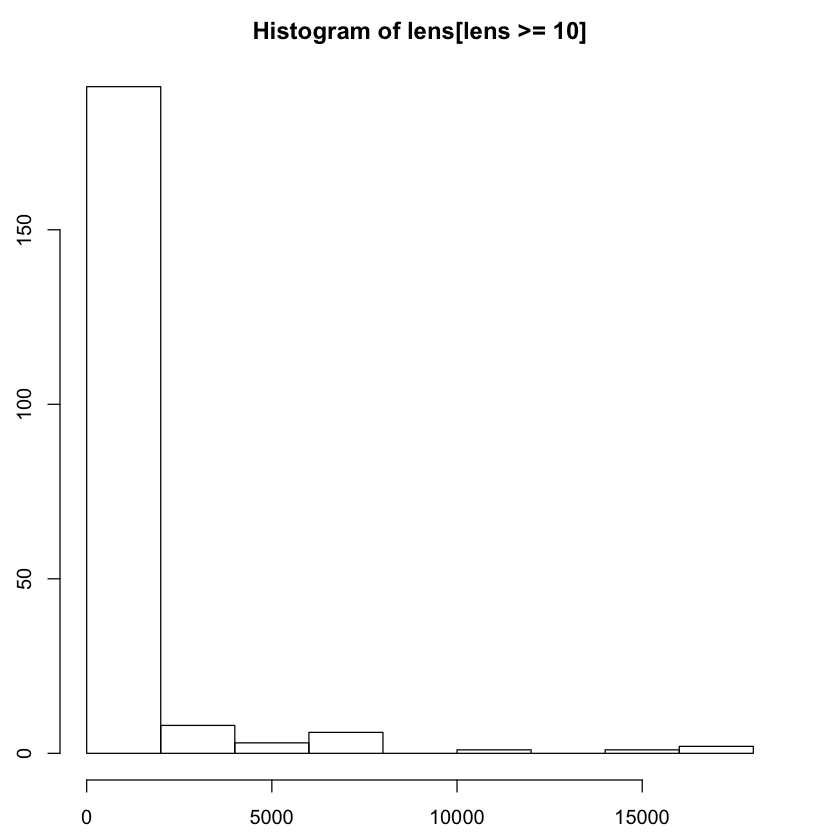

In [44]:
# if time for sim.matrix computation is too long then drop items with few users
lens = apply(items,1, function(row) length(which(!is.na(row))))
cat("#items with many users=", length(which(lens>=10)), "from", nrow(items), "\n")
par(mai=c(0.5,0.5,0.5,0.5)) # reset plot margins
hist(lens[lens>=10])

In [45]:
items = items[lens >= 10,]
dim(items)

[1]   212 64455

In [46]:
# calc sim matrix
itemsims = getitemsimsmatrix(items, FUN = jacardsim)  # takes a few minutes
itemsims = getitemsimsmatrix(items, FUN = cosinesim) 
itemsims = getitemsimsmatrix(items, FUN = euclidsim) 

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [47]:
# examine the sim matrix
fillrate(itemsims)
itemsims[1:20,1:20]

100 %

,/,//,/base-ops/procurement/,/biomed/,/de/,/facilities/,/facts/,/facts/internet/,/history/,/history/apollo-13/,/history/apollo/,/history/apollo/a-001/,/history/apollo/a-002/,/history/apollo/a-003/,/history/apollo/a-004/,/history/apollo/apollo-1/,/history/apollo/apollo-10/,/history/apollo/apollo-11/,/history/apollo/apollo-12/,/history/apollo/apollo-13/
/,1.00000000,0.2052131,0.2052131,0.3660254,0.2742919,0.02880232,0.03448276,0.1951941,0.03288297,0.2898979,0.03480579,0.14639248,0.2171293,0.2316625,0.1951941,0.06289441,0.08598344,0.05390856,0.09584069,0.03941335
//,0.20521310,1.0000000,0.5000000,1.0000000,0.5000000,0.26120387,0.24025307,0.4142136,0.26120387,0.5000000,0.25000000,0.41421356,0.4142136,1.0000000,1.0000000,0.30901699,0.30901699,0.27429189,0.28989795,0.25000000
/base-ops/procurement/,0.20521310,0.5000000,1.0000000,1.0000000,0.3333333,0.22400924,0.24025307,0.5000000,0.24025307,1.0000000,0.27429189,0.41421356,1.0000000,1.0000000,0.5000000,0.27429189,0.33333333,0.25000000,0.27429189,0.26120387
/biomed/,0.36602540,1.0000000,1.0000000,1.0000000,1.0000000,0.50000000,1.00000000,1.0000000,0.50000000,1.0000000,0.50000000,1.00000000,1.0000000,1.0000000,1.0000000,0.50000000,1.00000000,1.00000000,1.00000000,0.50000000
/de/,0.27429189,0.5000000,0.3333333,1.0000000,1.0000000,0.26120387,0.28989795,0.4142136,0.30901699,1.0000000,0.30901699,0.50000000,1.0000000,1.0000000,1.0000000,0.30901699,0.41421356,0.30901699,0.41421356,0.33333333
/facilities/,0.02880232,0.2612039,0.2240092,0.5000000,0.2612039,1.00000000,0.03993350,0.1907436,0.03873065,0.3090170,0.03545730,0.12849622,0.1791288,0.2052131,0.1589445,0.06780706,0.08365085,0.05202679,0.09584069,0.03983438
/facts/,0.03448276,0.2402531,0.2402531,1.0000000,0.2898979,0.03993350,1.00000000,0.1866055,0.05475649,0.3090170,0.05993627,0.18660550,0.2612039,0.2898979,0.2500000,0.09890773,0.13231996,0.08429727,0.14285714,0.06698647
/facts/internet/,0.19519410,0.4142136,0.5000000,1.0000000,0.4142136,0.19074357,0.18660550,1.0000000,0.21089672,1.0000000,0.24025307,0.41421356,1.0000000,1.0000000,0.5000000,0.24025307,0.41421356,0.30901699,0.41421356,0.23166248
/history/,0.03288297,0.2612039,0.2402531,0.5000000,0.3090170,0.03873065,0.05475649,0.2108967,1.00000000,0.2898979,0.03476219,0.12500000,0.1951941,0.2052131,0.1725378,0.05432747,0.08365085,0.05173225,0.08301951,0.03743927
/history/apollo-13/,0.28989795,0.5000000,1.0000000,1.0000000,1.0000000,0.30901699,0.30901699,1.0000000,0.28989795,1.0000000,0.28989795,0.50000000,1.0000000,1.0000000,1.0000000,0.33333333,0.33333333,0.28989795,0.41421356,0.28989795


fillrate= 100 %avg sim= 0.4191832 median sim= 0.309017

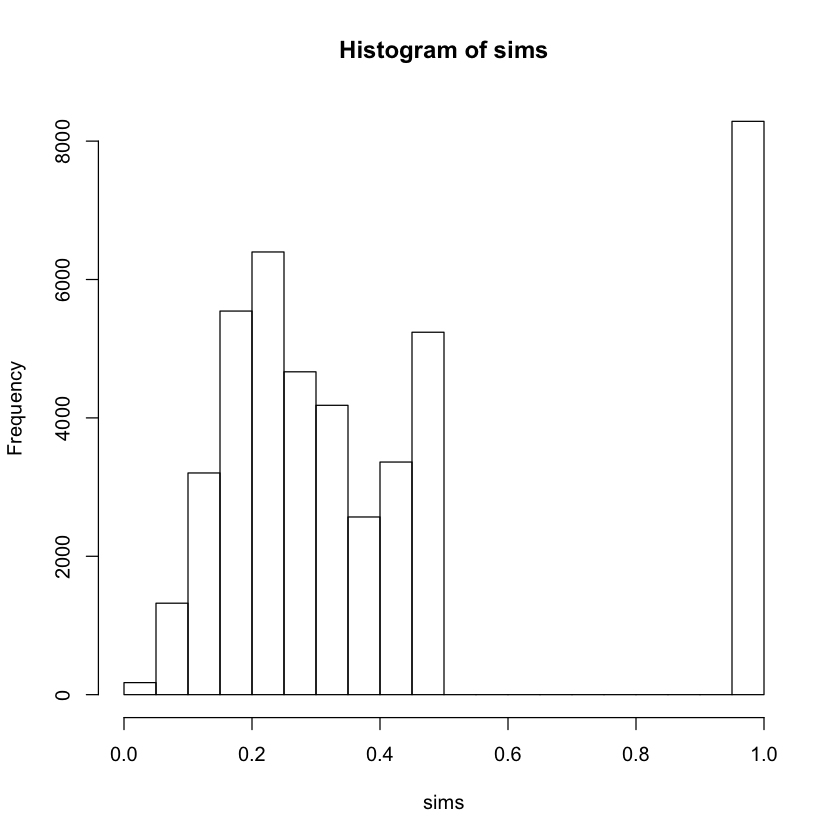

In [48]:
# should we make 0's into NA's in the sim matrix? (only an issue for Jaccard sim?)
# how many 0's are there?
sims = unlist(as.list(itemsims))
cat("fillrate=",length(which(sims>0))*100/length(sims),"%")
cat("avg sim=", mean(sims), "median sim=", median(sims))
hist(sims)

In [49]:
getrecommendations_II(target, items, itemsims)

/software/techdoc/             /payloads/processing/ 
                         1.714286                          1.673903 
              /history/apollo-13/            /base-ops/procurement/ 
                         1.666667                          1.660321 
/shuttle/countdown/lps/bkup-intg/ 
                         1.656814

In [50]:
# perform the test, but only test users with >=3 items (for each test ensures >=2 to make the prediction)
pvcnts = sapply(colnames(items), function(host) length(which(!is.na(items[,host])))) # count items for each host

In [51]:
items2 = items[,pvcnts>=3] ; dim(items2)
numtestusers = 50
testusers  = sample(colnames(items2), min(numtestusers,length(colnames(items2)))) # identify users randomly for testing
testusers

[1]   212 22183

[1] "133.82.129.109"               "192.197.125.10"              
 [3] "pm2-48.skypoint.net"          "163.197.34.15"               
 [5] "163.205.154.17"               "slip179.centcon.com"         
 [7] "toffee.eng.uci.edu"           "157.110.6.158"               
 [9] "202.39.79.23"                 "13.1.64.94"                  
[11] "phys.physics.ucf.edu"         "202.244.231.33"              
[13] "ppp-39.accent.net"            "198.163.179.4"               
[15] "ppp033.yk.rim.or.jp"          "cedric.onthenet.com.au"      
[17] "phr-add-mac52.phr.utexas.edu" "stsim.interax.net"           
[19] "concept.break.com.au"         "mtrsppp46.epix.net"          
[21] "annex002.ridgecrest.ca.us"    "dffl6-30.gate.net"           
[23] "198.165.248.10"               "jmols_pc.ea.com"             
[25] "thimble-d221.sierra.net"      "staylor.seanet.com"          
[27] "ad19-004.compuserve.com"      "168.95.124.29"               
[29] "163.205.42.43"                "137.194.66.120"              
[31] "chekrau1.ucsd.edu"            "140.178.7.43"                
[33] "haehner.gsfc.nasa.gov"        "nb1-du12.polarnet.fnsb.ak.us"
[35] "s90-win20.lbl.gov"            "wa95.htp.net"                
[37] "131.110.53.48"                "pm-1-24.connectnet.com"      
[39] "mfg-51.umd.edu"               "thor.obsti.se"               
[41] "ix-dgr-il1-16.ix.netcom.com"  "anticlea.scl.ameslab.gov"    
[43] "opt302_b3.opt.indiana.edu"    "public.iunet.it"             
[45] "129.74.251.154"               "stockyard58.onramp.net"      
[47] "dd19-016.compuserve.com"      "bend2.bendnet.com"           
[49] "204.19.33.83"                 "ice.priconet.de"

In [52]:
preds = predictCF(testusers, itemrats=items2, itemsims=itemsims, numtestitems=10, random=FALSE)
preds
cat("avg MAE =",avgMAE(preds))

..................................................

133.82.129.109,192.197.125.10,pm2-48.skypoint.net,163.197.34.15,163.205.154.17,slip179.centcon.com,toffee.eng.uci.edu,157.110.6.158,202.39.79.23,13.1.64.94,⋯,ix-dgr-il1-16.ix.netcom.com,anticlea.scl.ameslab.gov,opt302_b3.opt.indiana.edu,public.iunet.it,129.74.251.154,stockyard58.onramp.net,dd19-016.compuserve.com,bend2.bendnet.com,204.19.33.83,ice.priconet.de
1.379252,1,1.509888,1,1.489184,1.136953,1.432697,1,1.337463,1.35405,⋯,1,1.698632,1,1,1.216702,1.218037,1.081085,1.551561,1,1.244438
1,1,1,1,2,1,2,1,1,1,⋯,1,2,1,1,1,1,1,2,1,1
1,1,1.629014,1,1.603685,1.254553,1.627014,1,1,1.202706,⋯,1,1.644173,1,1,1.225148,1.195211,1.067601,2,1,1.330722
2,1,1,1,1,1,1,1,2,1,⋯,1,2,1,1,1,1,1,1,1,1
1.453253,1,1,1,1.555639,1.140349,1.419473,1,1.414475,1.254661,⋯,1,2,1,1,1.217119,1.168148,1.092747,1.519332,1,1.26239
1,1,2,1,1,1,2,1,1,1,⋯,1,1,1,1,1,1,1,2,1,1
1.434392,NA,NA,NA,1.560784,1,1.480102,NA,NA,1,⋯,1,1.694015,1,1,1,1.127673,1.102325,1.546872,1,1
1,NA,NA,NA,1,2,2,NA,NA,2,⋯,1,2,1,1,2,2,1,2,1,2
NA,NA,NA,NA,1.515104,NA,1.623536,NA,NA,NA,⋯,1,NA,NA,1,1.271193,1.137547,1.06537,NA,1,NA
NA,NA,NA,NA,2,NA,1,NA,NA,NA,⋯,1,NA,NA,1,1,2,1,NA,1,NA


avg MAE = 0.2762061

In [53]:
# What likethresh to use? Note that all ratings are either 1 or 2 so pred is >=1 always
showCM(preds, like=1.5)

accuracy = 75.2%
TN=180 FP= 23
FN= 39 TP=  8     recall=17.0%
       pr= 25.8%

In [54]:
showCM(preds, like=1.1)

accuracy = 53.2%
TN=107 FP= 96
FN= 21 TP= 26     recall=55.3%
       pr= 21.3%

In [55]:
# results look good, but probably to much "if fish then fish" ~ recommending too similar items (see pvcats below)
sort(unique(rownames(items2)))

[1] "/"                                        
  [2] "//"                                       
  [3] "/base-ops/procurement/"                   
  [4] "/biomed/"                                 
  [5] "/de/"                                     
  [6] "/facilities/"                             
  [7] "/facts/"                                  
  [8] "/facts/internet/"                         
  [9] "/history/"                                
 [10] "/history/apollo-13/"                      
 [11] "/history/apollo/"                         
 [12] "/history/apollo/a-001/"                   
 [13] "/history/apollo/a-002/"                   
 [14] "/history/apollo/a-003/"                   
 [15] "/history/apollo/a-004/"                   
 [16] "/history/apollo/apollo-1/"                
 [17] "/history/apollo/apollo-10/"               
 [18] "/history/apollo/apollo-11/"               
 [19] "/history/apollo/apollo-12/"               
 [20] "/history/apollo/apollo-13/"               
 [21] "/history/apollo/apollo-14/"               
 [22] "/history/apollo/apollo-15/"               
 [23] "/history/apollo/apollo-16/"               
 [24] "/history/apollo/apollo-17/"               
 [25] "/history/apollo/apollo-4/"                
 [26] "/history/apollo/apollo-5/"                
 [27] "/history/apollo/apollo-6/"                
 [28] "/history/apollo/apollo-7/"                
 [29] "/history/apollo/apollo-8/"                
 [30] "/history/apollo/apollo-9/"                
 [31] "/history/apollo/as-201/"                  
 [32] "/history/apollo/as-202/"                  
 [33] "/history/apollo/as-203/"                  
 [34] "/history/apollo/pad-abort-test-1/"        
 [35] "/history/apollo/pad-abort-test-2/"        
 [36] "/history/apollo/sa-1/"                    
 [37] "/history/apollo/sa-10/"                   
 [38] "/history/apollo/sa-2/"                    
 [39] "/history/apollo/sa-3/"                    
 [40] "/history/apollo/sa-4/"                    
 [41] "/history/apollo/sa-5/"                    
 [42] "/history/apollo/sa-6/"                    
 [43] "/history/apollo/sa-7/"                    
 [44] "/history/apollo/sa-8/"                    
 [45] "/history/apollo/sa-9/"                    
 [46] "/history/astp/"                           
 [47] "/history/gemini/"                         
 [48] "/history/gemini/gemini-1/"                
 [49] "/history/gemini/gemini-2/"                
 [50] "/history/gemini/gemini-3/"                
 [51] "/history/gemini/gemini-4/"                
 [52] "/history/gemini/gemini-ix-a/"             
 [53] "/history/gemini/gemini-v/"                
 [54] "/history/gemini/gemini-vi-a/"             
 [55] "/history/gemini/gemini-vii/"              
 [56] "/history/gemini/gemini-viii/"             
 [57] "/history/gemini/gemini-x/"                
 [58] "/history/gemini/gemini-xi/"               
 [59] "/history/gemini/gemini-xii/"              
 [60] "/history/mercury/"                        
 [61] "/history/mercury/ma-6/"                   
 [62] "/history/mercury/ma-7/"                   
 [63] "/history/mercury/ma-8/"                   
 [64] "/history/mercury/ma-9/"                   
 [65] "/history/mercury/mr-3/"                   
 [66] "/history/mercury/mr-4/"                   
 [67] "/history/skylab/"                         
 [68] "/mdss/"                                   
 [69] "/mdss/ped/acs/"                           
 [70] "/mdss/srqa/../"                           
 [71] "/mdss/srqa/qpa/"                          
 [72] "/msfc/"                                   
 [73] "/msfc/crew/"                              
 [74] "/msfc/description/"                       
 [75] "/msfc/description/instruments/"           
 [76] "/msfc/description/shuttle/"               
 [77] "/msfc/onboard/"                           
 [78] "/msfc/team/"                              
 [79] "/payloads/"                               
 [80] "/payloads/org/"                           
 [